## Part 1: Creating A Repository And Working With Data

This tutorial will review the first steps of working with a hangar repository.

To fit with the beginner's theme, we will use the MNIST dataset. Later examples will show off how to work with much more complex data.

In [1]:
from hangar import Repository

import numpy as np
import pickle
import gzip
import matplotlib.pyplot as plt

from tqdm import tqdm

### Creating & Interacting with a Hangar Repository

Hangar is designed to “just make sense” in every operation you have to perform.
As such, there is a single interface which all interaction begins with: the
 designed to “just make sense” in every operation you have to perform.
As such, there is a single interface which all interaction begins with: the
[Repository](api.rst#hangar.repository.Repository) object.

Whether a hangar repository exists at the path you specify or not, just tell
hangar where it should live!

#### Intitializing a repository

The first time you want to work with a new repository, the repository
[init()](api.rst#hangar.repository.Repository.init) method
must be called. This is where you provide Hangar with your name and email
address (to be used in the commit log), as well as implicitly confirming that
you do want to create the underlying data files hangar uses on disk.

In [2]:
repo = Repository(path='/Users/rick/projects/tensorwerk/hangar/dev/mnist/')

# First time a repository is accessed only!
# Note: if you feed a path to the `Repository` which does not contain a pre-initialized hangar repo,
# when the Repository object is initialized it will let you know that you need to run `init()`

repo.init(user_name='Rick Izzo', user_email='rick@tensorwerk.com', remove_old=True)

Hangar Repo initialized at: /Users/rick/projects/tensorwerk/hangar/dev/mnist/.hangar


'/Users/rick/projects/tensorwerk/hangar/dev/mnist/.hangar'

#### Checking out the repo for writing

A repository can be checked out in two modes:

1. [write-enabled](api.rst#hangar.checkout.WriterCheckout): applies all operations to the staging area’s current
   state. Only one write-enabled checkout can be active at a different time,
   must be closed upon last use, or manual intervention will be needed to remove
   the writer lock.

2. [read-only](api.rst#read-only-checkout): checkout a commit or branch to view repository state as it
   existed at that point in time.

#### Lots of useful information is in the iPython `__repr__`

If you're ever in doubt about what the state of the object your working
on is, just call its reps, and the most relevant information will be
sent to your screen!

In [3]:
co = repo.checkout(write=True)
co

Hangar WriterCheckout                
    Writer       : True                
    Base Branch  : master                
    Num Columns  : 0


#### A checkout allows access to [columns](api.rst#hangar.columns.column.Columns)

The [columns](api.rst#hangar.checkout.WriterCheckout.columns) attributes
of a checkout provide the interface to working with all of the data on disk!

In [4]:
co.columns

Hangar Columns                
    Writeable         : True                
    Number of Columns : 0                
    Column Names / Partial Remote References:                
      - 

### Before data can be added to a repository, a column must be initialized.

We're going to first load up a the MNIST pickled dataset so it can be added to
the repo!

In [6]:
# Load the dataset
with gzip.open('/Users/rick/projects/tensorwerk/hangar/dev/data/mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='bytes')

def rescale(array):
    array = array * 256
    rounded = np.round(array)
    return rounded.astype(np.uint8())

sample_trimg = rescale(train_set[0][0])
sample_trlabel = np.array([train_set[1][0]])
trimgs = rescale(train_set[0])
trlabels = train_set[1]

#### Before data can be added to a repository, a column must be initialized.

An "Column" is a named grouping of data samples where each sample shares a
number of similar attributes and array properties.

See the docstrings below or in [add_ndarray_column()](api.rst#hangar.checkout.WriterCheckout.add_ndarray_column)

.. include:: ./noindexapi/apiinit.rst

In [7]:
col = co.add_ndarray_column(name='mnist_training_images', prototype=trimgs[0])

In [8]:
col

Hangar FlatSampleWriter                 
    Column Name              : mnist_training_images                
    Writeable                : True                
    Column Type              : ndarray                
    Column Layout            : flat                
    Schema Type              : fixed_shape                
    DType                    : uint8                
    Shape                    : (784,)                
    Number of Samples        : 0                
    Partial Remote Data Refs : False


### Interaction

#### Through columns attribute

When a column is initialized, a column accessor object will be returned,
however, depending on your use case, this may or may not be the most convenient
way to access a arrayset.

In general, we have implemented a full `dict` mapping interface on top of all
objects. To access the `'mnist_training_images'` arrayset you can just use a
dict style access like the following (note: if operating in iPython/Jupyter, the
arrayset keys will autocomplete for you).

The column objects returned here contain many useful instrospecion methods which
we will review over the rest of the tutorial.

In [9]:
co.columns['mnist_training_images']

Hangar FlatSampleWriter                 
    Column Name              : mnist_training_images                
    Writeable                : True                
    Column Type              : ndarray                
    Column Layout            : flat                
    Schema Type              : fixed_shape                
    DType                    : uint8                
    Shape                    : (784,)                
    Number of Samples        : 0                
    Partial Remote Data Refs : False


In [10]:
train_aset = co.columns['mnist_training_images']

# OR an equivalent way using the `.get()` method

train_aset = co.columns.get('mnist_training_images')
train_aset

Hangar FlatSampleWriter                 
    Column Name              : mnist_training_images                
    Writeable                : True                
    Column Type              : ndarray                
    Column Layout            : flat                
    Schema Type              : fixed_shape                
    DType                    : uint8                
    Shape                    : (784,)                
    Number of Samples        : 0                
    Partial Remote Data Refs : False


#### Through the checkout object (arrayset and sample access)

In addition to the standard `co.columns` access methods, we have implemented a convenience mapping to [columns](api.rst#hangar.columns.column.Columns) and [flat samples](api.rst#hangar.columns.layout_flat.FlatSampleWriter) or [nested samples](api.rst#hangar.columns.layout_nested.NestedSampleWriter) / [nested subsamples](api.rst#hangar.columns.layout_nested.FlatSubsampleWriter) (ie. data) for both reading and writing from the [checkout](api.rst#hangar.checkout.WriterCheckout) object itself.

To get the same arrayset object from the checkout, simply use:

In [11]:
train_asets = co['mnist_training_images']
train_asets

Hangar FlatSampleWriter                 
    Column Name              : mnist_training_images                
    Writeable                : True                
    Column Type              : ndarray                
    Column Layout            : flat                
    Schema Type              : fixed_shape                
    DType                    : uint8                
    Shape                    : (784,)                
    Number of Samples        : 0                
    Partial Remote Data Refs : False


Though that works as expected, most use cases will take advantage of adding and reading data from multiple columns / samples at a time. This is shown in the next section.

#### Adding Data

To add data to a named arrayset, we can use dict-style setting
(refer to the `__setitem__`, `__getitem__`, and `__delitem__` methods),
or the `update()` method. Sample keys can be either `str` or `int` type.

In [12]:
train_aset['0'] = trimgs[0]

data = {
    '1': trimgs[1],
    '2': trimgs[2],
}
train_aset.update(data)

train_aset[51] = trimgs[51]

Using the checkout method

In [13]:
co['mnist_training_images', 60] = trimgs[60]

#### How many samples are in the arrayset?

In [14]:
len(train_aset)

5

#### Containment Testing

In [15]:
'hi' in train_aset

False

In [16]:
'0' in train_aset

True

In [17]:
60 in train_aset

True

#### Dictionary Style Retrieval for known keys

True


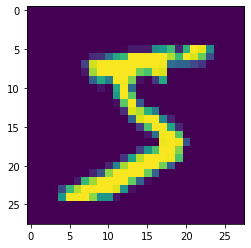

In [18]:
out1 = train_aset['0']
# OR
out2 = co['mnist_training_images', '0']

print(np.allclose(out1, out2))

plt.imshow(out1.reshape(28, 28))

### Dict style iteration supported out of the box

0
1
2
51
60


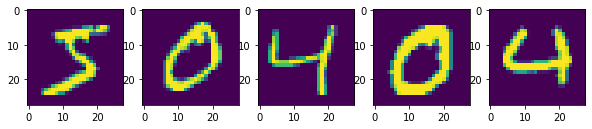

In [19]:
# iterate normally over keys

for k in train_aset:
    # equivalent method: for k in train_aset.keys():
    print(k)

# iterate over items (plot results)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))

for idx, v in enumerate(train_aset.values()):
    axs[idx].imshow(v.reshape(28, 28))
plt.show()

# iterate over items, store k, v in dict

myDict = {}
for k, v in train_aset.items():
    myDict[k] = v

### Performance

Once you’ve completed an interactive exploration, be sure to use the context
manager form of the `update()` and `get()` methods!

In order to make sure that all your data is always safe in Hangar, the backend
diligently ensures that all contexts (operations which can somehow interact
with the record structures) are opened and closed appropriately. When you use the
context manager form of a arrayset object, we can offload a significant amount of
work to the python runtime, and dramatically increase read and write speeds.

Most columns we’ve tested see an increased throughput differential of 250% -
500% for writes and 300% - 600% for reads when comparing using the context
manager form vs the naked form!

In [23]:
import time

# ----------------- Non Context Manager Form ----------------------

co = repo.checkout(write=True)
aset_trimgs = co.add_ndarray_column(name='train_images', prototype=sample_trimg)
aset_trlabels = co.add_ndarray_column(name='train_labels', prototype=sample_trlabel)

print(f'Beginning non-context manager form')
print('----------------------------------')
start_time = time.time()

for idx, img in enumerate(trimgs):
    aset_trimgs[idx] = img
    aset_trlabels[idx] = np.array([trlabels[idx]])

print(f'Finished non-context manager form in: {time.time() - start_time} seconds')

co.reset_staging_area()
co.close()

# ----------------- Context Manager Form --------------------------

co = repo.checkout(write=True)
aset_trimgs = co.add_ndarray_column(name='train_images', prototype=sample_trimg)
aset_trlabels = co.add_ndarray_column(name='train_labels', prototype=sample_trlabel)

print(f'\nBeginning context manager form')
print('--------------------------------')
start_time = time.time()

with aset_trimgs, aset_trlabels:
    for idx, img in enumerate(trimgs):
        aset_trimgs[idx] = img
        aset_trlabels[idx] = np.array([trlabels[idx]])

print(f'Finished context manager form in: {time.time() - start_time} seconds')

co.reset_staging_area()
co.close()

print(f'Finished context manager with checkout form in: {time.time() - start_time} seconds')

Beginning non-context manager form
----------------------------------
Finished non-context manager form in: 78.54769086837769 seconds
Hard reset requested with writer_lock: 8910b50e-1f9d-4cb1-986c-b99ea84c8a54

Beginning context manager form
--------------------------------
Finished context manager form in: 11.608536720275879 seconds
Hard reset requested with writer_lock: ad4a2ef9-8494-49f8-84ef-40c3990b1e9b


Clearly, the context manager form is far and away superior, however we fell that
for the purposes of interactive use that the "Naked" form is valubal to the
average user!

### Commiting Changes

Once you have made a set of changes you want to commit, just simply call the [commit()](api.rst#hangar.checkout.WriterCheckout.commit) method (and pass in a message)!

In [25]:
co.commit('hello world, this is my first hangar commit')

'a=8eb01eaf0c657f8526dbf9a8ffab0a4606ebfd3b'

The returned value (`'e11d061dc457b361842801e24cbd119a745089d6'`) is the commit hash of this commit. It
may be useful to assign this to a variable and follow this up by creating a
branch from this commit!

#### Don't Forget to Close the Write-Enabled Checkout to Release the Lock!

We mentioned in `Checking out the repo for writing` that when a
`write-enabled` checkout is created, it places a lock on writers until it is
closed. If for whatever reason the program terminates via a non python `SIGKILL` or fatal
interpreter error without closing the
write-enabled checkout, this lock will persist (forever technically, but
realistically until it is manually freed).

Luckily, preventing this issue from occurring is as simple as calling
[close()](api.rst#hangar.checkout.WriterCheckout.close)!

If you forget, normal interperter shutdown should trigger an `atexit` hook automatically,
however this behavior should not be relied upon. Is better to just call
[close()](api.rst#hangar.checkout.WriterCheckout.close).

In [26]:
co.close()

#### But if you did forget, and you recieve a `PermissionError` next time you open a checkout

```
PermissionError: Cannot acquire the writer lock. Only one instance of
a writer checkout can be active at a time. If the last checkout of this
repository did not properly close, or a crash occured, the lock must be
manually freed before another writer can be instantiated.
```

You can manually free the lock with the following method. However!

This is a dangerous operation, and it's one of the only ways where a user can put
data in their repository at risk! If another python process is still holding the
lock, do NOT force the release. Kill the process (that's totally fine to do at
any time, then force the lock release).

In [27]:
repo.force_release_writer_lock()

True

### Reading Data

Two different styles of access are considered below, In general, the contex manager form
if recomended (though marginal performance improvements are expected to be seen at best)

In [29]:
co = repo.checkout()

trlabel_col = co['train_labels']
trimg_col = co['train_images']

print(f'\nBegining Key Iteration')
print('-----------------------')
start = time.time()

for idx in trimg_col.keys():
    image_data = trimg_col[idx]
    label_data = trlabel_col[idx]

print(f'completed in {time.time() - start} sec')

print(f'\nBegining Items Iteration with Context Manager')
print('---------------------------------------------')
start = time.time()

with trlabel_col, trimg_col:
    for index, image_data in trimg_col.items():
        label_data = trlabel_col[index]

print(f'completed in {time.time() - start} sec')

co.close()


 Neither BRANCH or COMMIT specified.
 * Checking out writing HEAD BRANCH: master

Begining Key Iteration
-----------------------
completed in 5.838773965835571 sec

Begining Items Iteration with Context Manager
---------------------------------------------
completed in 5.516948938369751 sec


### Inspecting state from the top!

After your first commit, the summary and log methods will begin to work, and you can either print the stream to the console (as shown below), or you can
dig deep into the internal of how hangar thinks about your data! (To be covered in an advanced tutorial later on).

The point is, regardless of your level of interaction with a live hangar repository, all level of state is accessable from the top, and in general has been built to be the only way to directly access it!

In [30]:
repo.summary()

Summary of Contents Contained in Data Repository 
 
| Repository Info 
|----------------- 
|  Base Directory: /Users/rick/projects/tensorwerk/hangar/dev/mnist 
|  Disk Usage: 57.29 MB 
 
| Commit Details 
------------------- 
|  Commit: a=8eb01eaf0c657f8526dbf9a8ffab0a4606ebfd3b 
|  Created: Tue Feb 25 19:03:06 2020 
|  By: Rick Izzo 
|  Email: rick@tensorwerk.com 
|  Message: hello world, this is my first hangar commit 
 
| DataSets 
|----------------- 
|  Number of Named Columns: 2 
|
|  * Column Name: ColumnSchemaKey(column="train_images", layout="flat") 
|    Num Data Pieces: 50000 
|    Details: 
|    - column_layout: flat 
|    - column_type: ndarray 
|    - schema_type: fixed_shape 
|    - shape: (784,) 
|    - dtype: uint8 
|    - backend: 00 
|    - backend_options: {'complib': 'blosc:lz4hc', 'complevel': 5, 'shuffle': 'byte'} 
|
|  * Column Name: ColumnSchemaKey(column="train_labels", layout="flat") 
|    Num Data Pieces: 50000 
|    Details: 
|    - column_layout: flat 
|   

In [31]:
repo.log()

* a=8eb01eaf0c657f8526dbf9a8ffab0a4606ebfd3b (master) : hello world, this is my first hangar commit
